# [All] Pre-extracted basic features

> Quick experiment trying to set different binary problems using pre-extracted features.

In this quick experiment we are going to utilize the pre-extracted features to perform different binary classification problems: We're going to try every possible binary problem to assess the difference in performance between them. Later we will jump into using an ensemble of binary classificators to predict all the classes.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rich.progress import track

import yasa
import mne

from sklearn.model_selection import train_test_split, cross_validate, GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

from sleepstagingidal.data import *
from sleepstagingidal.dataa import *
from sleepstagingidal.feature_extraction import *
from sleepstagingidal.cross_validation import *

In [ ]:
#| hide
path_data = "../02_Exporting_features/basic_features.csv"
path_info = "../info.csv"

## Load and filter the data

The first thing we have to do is loading the features we have previously extracted:

In [ ]:
df = pd.read_csv(path_data, index_col=0)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,76,77,78,79,80,81,82,83,Label,Patient
0,0.495066,0.112756,0.112814,0.064382,0.165632,0.049350,0.362000,0.116360,0.171950,0.159524,...,0.064126,0.025867,0.687305,0.084597,0.083275,0.047782,0.070681,0.026361,Sleep stage W,PSG29.edf
1,0.465074,0.117853,0.177654,0.101286,0.104765,0.033368,0.347451,0.205411,0.208832,0.093656,...,0.050156,0.026275,0.811640,0.054457,0.050954,0.026253,0.037776,0.018920,Sleep stage W,PSG29.edf
2,0.493321,0.083727,0.160615,0.093394,0.127338,0.041605,0.509627,0.099740,0.174744,0.106081,...,0.057003,0.022188,0.761949,0.065250,0.071764,0.036249,0.047086,0.017702,Sleep stage W,PSG29.edf
3,0.496456,0.078696,0.145985,0.073315,0.168728,0.036820,0.415612,0.150171,0.162990,0.084801,...,0.102050,0.051728,0.657698,0.107005,0.083062,0.039670,0.079945,0.032621,Sleep stage W,PSG29.edf
4,0.499096,0.090408,0.128249,0.119394,0.126275,0.036577,0.355009,0.114010,0.227973,0.142860,...,0.064617,0.030325,0.728514,0.062010,0.082649,0.035992,0.059911,0.030924,Sleep stage W,PSG29.edf


Adding to this, we are going to filter our data to keep only the complete patients. We can do so using the `info.csv` file we have previously created:

In [ ]:
df_info = pd.read_csv(path_info)
df_info.head()

,File,DifferentStages,Complete
0,PSG29.edf,3,False
1,PSG12.edf,5,True
2,PSG17.edf,5,True
3,PSG10.edf,4,False
4,PSG23.edf,3,False


If we keep only the complete patients from this dataframe and join it with the other one, we can filter out the incomplete patients to train only with the complete ones:

In [ ]:
df_info_complete = df_info[df_info.Complete]
len(df_info_complete)

30

We see that we are left with 30 out of 36 patients. Next we'll join both dataframes:

In [ ]:
df_complete = df.merge(right=df_info_complete, how="right", left_on="Patient", right_on="File")
df_complete = df_complete.drop(["Patient", "DifferentStages", "Complete"], axis=1)
df.shape, df_complete.shape

((27680, 86), (24121, 86))

In [ ]:
df_complete.head()

,0,1,2,3,4,5,6,7,8,9,...,76,77,78,79,80,81,82,83,Label,File
0,0.828777,0.111004,0.036347,0.013696,0.008029,0.002147,0.866095,0.077208,0.029721,0.013948,...,0.013523,0.011039,0.842687,0.082653,0.018246,0.008742,0.021826,0.025847,Sleep stage W,PSG12.edf
1,0.829209,0.104899,0.032051,0.022996,0.008892,0.001952,0.822251,0.105734,0.035186,0.024547,...,0.013242,0.009276,0.873665,0.057653,0.016445,0.013007,0.019579,0.019652,Sleep stage W,PSG12.edf
2,0.842406,0.100744,0.029417,0.019372,0.006586,0.001473,0.870060,0.081720,0.022897,0.017082,...,0.011098,0.008603,0.869873,0.061609,0.020109,0.010276,0.017389,0.020744,Sleep stage W,PSG12.edf
3,0.826268,0.114365,0.034281,0.016519,0.006972,0.001596,0.834174,0.086591,0.045124,0.020168,...,0.012120,0.009433,0.873901,0.055302,0.022631,0.009176,0.018615,0.020375,Sleep stage W,PSG12.edf
4,0.892040,0.072569,0.016537,0.013553,0.004228,0.001073,0.887429,0.069672,0.017843,0.017650,...,0.006212,0.005312,0.914073,0.043103,0.011320,0.007723,0.010389,0.013391,Sleep stage W,PSG12.edf


And we see that we have removed the corresponding 3559 rows corresponding to incomplete patients.

## Defining the metrics

> AUC can be a good metrics when working with binary problems.

To measure the performance of our classifier, we're going to use the AUC and the accuracy, the latter just for completion. Because we want to obtain the most realistic metric possible, we are going to perform a *Patient-Fold* where we train with all the patients and then test in a completelly different one. This will give us a good estimate of the generalization performance of our pipeline.

> This can be achieved using `cross_validate` in conjunction with `GroupKFold` and setting the `groups` parameter to be the `File` column in our previous dataframe.

We will perform a loop to perform cross-validation on each of the five possible binary classification problems:

In [ ]:
metrics_score = {
    "Accuracy": "accuracy",
    "AUC": "roc_auc",
}

In [ ]:
pos_labels = df_complete.Label.unique()
pos_labels

array(['Sleep stage W', 'Sleep stage N1', 'Sleep stage N2',
       'Sleep stage N3', 'Sleep stage R'], dtype=object)

In [ ]:
results = {}
for label in track(pos_labels):
    cvg = cross_validate(RandomForestClassifier(), 
                         X=df_complete.drop(["Label", "File"], axis=1),
                         y=df_complete["Label"]==label,
                         scoring=metrics_score,
                         return_train_score=True,
                         cv=GroupKFold(n_splits=len(df_complete.File.unique())),
                         groups=df_complete["File"],
                         n_jobs=6)
    results[label] = cvg

Output()

For plotting purpouses we can build a huge dataframe with all the data we obtained:

In [ ]:
dfs = []

for label, res in results.items():
    df_res_i = pd.DataFrame.from_dict(res)
    df_res_i['Binary'] = label
    dfs.append(df_res_i)

In [ ]:
dfs_total = pd.concat(dfs)
print(dfs_total.shape)
dfs_total.head()

(150, 7)


,fit_time,score_time,test_Accuracy,train_Accuracy,test_AUC,train_AUC,Binary
0,38.173372,0.074652,0.732424,1.0,0.907228,1.0,Sleep stage W
1,36.354859,0.068716,0.663736,1.0,0.752617,1.0,Sleep stage W
2,35.902291,0.092104,0.828798,1.0,0.891056,1.0,Sleep stage W
3,36.459545,0.093932,0.952000,1.0,0.968489,1.0,Sleep stage W
4,35.683652,0.098985,0.866354,1.0,0.915691,1.0,Sleep stage W


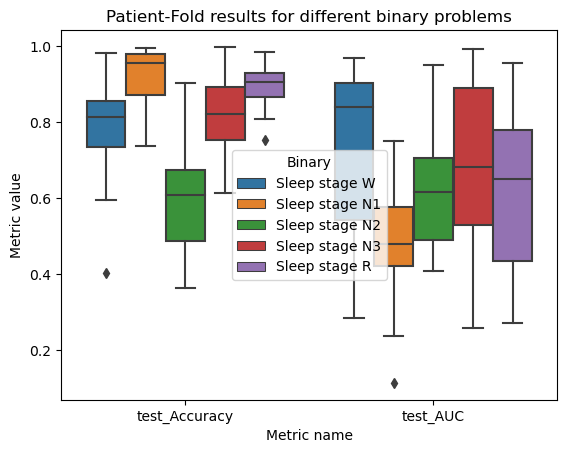

In [ ]:
dfs_total.drop(["fit_time", "score_time", "train_Accuracy", "train_AUC"], axis=1)\
         .melt(id_vars='Binary')\
         .pipe((sns.boxplot, "data"), x="variable", y="value", hue="Binary")
plt.xlabel("Metric name")
plt.ylabel("Metric value")
plt.title("Patient-Fold test results for different binary problems")
plt.show()

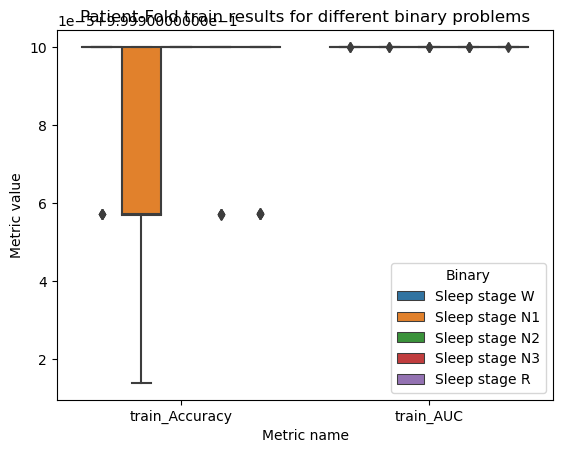

In [ ]:
dfs_total.drop(["fit_time", "score_time", "test_Accuracy", "test_AUC"], axis=1)\
         .melt(id_vars='Binary')\
         .pipe((sns.boxplot, "data"), x="variable", y="value", hue="Binary")
plt.xlabel("Metric name")
plt.ylabel("Metric value")
plt.title("Patient-Fold train results for different binary problems")
plt.show()